# Authors:
- Guijas Bravo, Pedro
- Miguélez Millos, Ángel

# 1. Initial setup

First of all, we will mount or Google Drive account to access faster the dataset. Otherwise, it would take a lot to upload the whole dataset each time to the Colab session.

This step is only necessary if you execute the notebook in Colab and if you have the dataset saved in your Drive account. Please, skip it in any other case.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ZIP_PATH = '/content//drive/MyDrive/'
!unzip -q {ZIP_PATH}/faces_dataset_train.zip -d ./
!unzip -q {ZIP_PATH}/faces_dataset_test.zip -d ./

Also, we will downgrade the tensorflow version in order to fix a bug related to data augmentation since the last versions work very slow when using it.

In [ ]:
!pip install tensorflow==2.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.5/498.5 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successf

# 2. Load dataset

This step will load and prepare the dataset for training. **Set the path to the train and test dataset folders in the `PATH` and `PATH_TEST` variables.**

Some comments about the dataset:

- The dataset is split into train and test (validation) subsets.
- Each image is a 32x32x3 tensor (RGB).
- Images are normalized between [-1, 1] to facilitate the learning process of the networks.
- Each label represents the age of the person in the image.
- Labels are normalized between [0, 1] by dividing by the maximum age in the dataset (`max_age = 99`).
- In each batch iteration, 128 images are seen.

In [ ]:
# Dataset path
from os import listdir
import os.path

# Set the paths to our datasets
PATH = './faces_dataset_train/'
PATH_TEST = './faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

### Metadata access

In [ ]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


### Image reading

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Image shape:  (32, 32, 3)
Label:  43


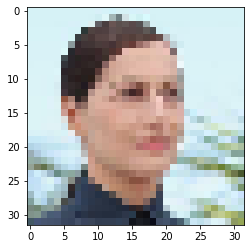

Image shape:  (32, 32, 3)
Label:  55


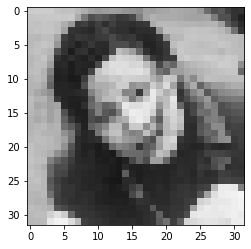

Image shape:  (32, 32, 3)
Label:  23


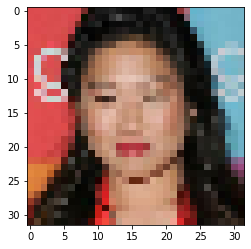

Image shape:  (32, 32, 3)
Label:  36


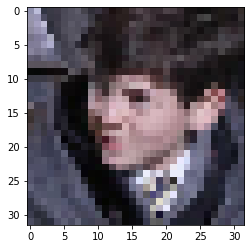

Image shape:  (32, 32, 3)
Label:  67


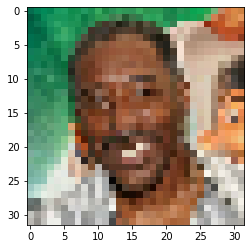

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    age = parts[1]
    age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
    gender = parts[2]
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, age


def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    plt.imshow(image.numpy())
    plt.show()

In [ ]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

./faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M


In [ ]:
# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

In [ ]:
# OPTIONAL: rescaled output to [0, 1]
import numpy as np
labels = [int(x.split('|')[1]) for x in train_metadata]
max_age = tf.convert_to_tensor(np.max(labels), tf.float32)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))

In [ ]:
# OPTIONAL: sample age weights
# import numpy as np
# step = 10
# labels = [int(x.split('|')[1]) for x in train_metadata]
# freqs, bins = np.histogram(labels, bins=list(range(0,100,step)) + [200])
# i_freqs = 1. / freqs
# sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
# print(sample_weights)
# ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))
# ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))

In [ ]:
batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

# 3. Transfer learning with the gender CNN model

The following cells will train some of the networks considered, saving checkpoints in the `CHECKPOINTS_FOLDER` folder. Please, change the path to an appropiate one of your system/account. Also, you can set later the `checkpoint` key of the hyperparameters to `None` in order to not save the model.

In [ ]:
CHECKPOINTS_FOLDER = "/content/drive/MyDrive/Checkpoints/"

## Define the pipeline

This subsection includes all the functions needed to load, train and show the results of the training of a network.

Multiple times, we do not have large datasets or the time to train a whole deep learning model. In that case, we can apply **transfer learning** to reuse an already trained model on another dataset, more general or similar to the one we have, to obtain a new model specific for our problem. The natural representation of the features in a CNN makes it easy to reuse the model since only the last layers, corresponding to the most abstract patterns, should be replaced. We can follow two approaches:

- **Feature extractor**: we use the old model as a feature extractor for our new classificator, trained from zero. The old convolutional layers are frozen and not adapted to the new problem. Since in our case the dataset is the same, that should not be a problem.

- **Fine tune**: some layers convolutional layers are also trained (not from zero). Usually, only the last layers are fine-tuned, since they represent the most abstract patterns specific of a given problem.

In [ ]:
from tensorflow import keras
from keras import layers

def load_model(checkpoint, n_fine_tuned_layers=0, dropout=False):

  old_model = keras.models.load_model(checkpoint)
  old_model.trainable = False

  new_model = keras.Sequential(name="cnn_age")

  # Frozen layers
  for layer in old_model.layers[:-(2+n_fine_tuned_layers+dropout)]:
    new_model.add(layer)

  # Layers to fine tune (0 to follow a feature extractor approach)
  for layer in old_model.layers[-(2+n_fine_tuned_layers+dropout):-(2+dropout)]:
    layer.trainable = True
    new_model.add(layer)

  # Replace the whole classificator module since they are different problems
  new_model.add(layers.Dense(1024, activation="relu", name="dense1"))
  if (dropout):
    new_model.add(layers.Dropout(0.25, name="dropout_dense"))
  new_model.add(layers.Dense(1, name="dense2"))  # no activation = linear

  new_model.summary()

  return new_model

In [ ]:
from keras import optimizer_v2

def train_model(model, ds_train_batch, ds_test_batch, epochs=20, lr=0.001, optimizer=optimizer_v2.adam.Adam, checkpoint=None, lr_scheduler=None, early_stop=None):

  model.compile(optimizer=optimizer(learning_rate=lr),
                loss="mean_squared_error",
                metrics=["mean_absolute_error"])

  callbacks = []
  if checkpoint is not None:
    callbacks.append(checkpoint)
  if lr_scheduler is not None:
    callbacks.append(lr_scheduler)
  if early_stop is not None:
    callbacks.append(early_stop)

  history = model.fit(ds_train_batch, epochs=epochs, validation_data=ds_test_batch, callbacks=callbacks)
  return history

We will show the evolution of the loss and the accuracy in the training and validation subsets.

In [ ]:
def plot_results(history, unnormalize_factor):

  history = history.history
  loss, val_loss = history['loss'], history['val_loss']
  mean_absolute_error, val_mean_absolute_error = history['mean_absolute_error'], history['val_mean_absolute_error']

  epochs = range(1, len(loss) + 1)
  fig, axs = plt.subplots(1, 2, figsize=(9,4))

  for idx, measure in enumerate(["loss", "mean_absolute_error"]):
    axs[idx].plot(epochs, eval(measure) * unnormalize_factor, 'b-o', label=f'Training {measure}')
    axs[idx].plot(epochs, eval(f"val_{measure}") * unnormalize_factor, 'r-o', label=f'Validation {measure}')
    axs[idx].set_title(f'Training and validation {measure}')
    axs[idx].set_xlabel('Epochs')
    axs[idx].set_ylabel(measure.capitalize())
    axs[idx].legend()

  plt.tight_layout()
  plt.show()

In [ ]:
from keras import utils

def execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters, dropout=False, seed=1):

  # Set the seed to allow reproducibility
  utils.tf_utils.set_random_seed(seed)

  model = load_model(CHECKPOINTS_FOLDER + hyperparameters["checkpoint_genre"], n_fine_tuned_layers=hyperparameters["n_fine_tuned_layers"], dropout=dropout)
  history = train_model(model, ds_train_batch, ds_test_batch, hyperparameters["epochs"],
                        hyperparameters["lr"], hyperparameters["optimizer"],
                        hyperparameters["checkpoint"], hyperparameters["lr_scheduler"], hyperparameters["early_stop"])
  plot_results(history, max_age)

  return model, history

## Perform the transfer learning

This subsection contains the execution of some of the configurations tested. The discussion is reserved for the next section.

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

Model: "cnn_age"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048)              0   

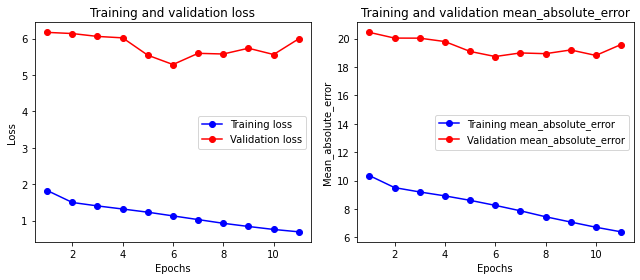

In [ ]:
# Baseline model
checkpoint_filename = "cnn_age_lr0.001_epoch{epoch}"
hyperparameters = {
    "checkpoint_genre": "cnn_genre_lr0.001_epoch7",

    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "n_fine_tuned_layers": 0,  # apart from the Denses, starting from the bottom of the network

    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_age"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 dropout1 (Dropout)          (None, 32, 32, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 dropout2 (Dropout)          (None, 16, 16, 64)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 8, 8, 128)         7385

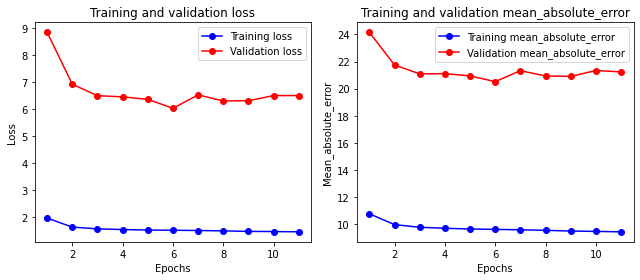

In [ ]:
# Best genre model (in terms of validation accuracy: dropout)
checkpoint_filename = "cnn_age_lr0.001_epoch{epoch}_dropout"
hyperparameters = {
    "checkpoint_genre": "cnn_genre_lr0.001_epoch5_dropout",

    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "n_fine_tuned_layers": 0,  # apart from the Denses, starting from the bottom of the network

    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters, True)

Model: "cnn_age"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 dropout1 (Dropout)          (None, 32, 32, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 dropout2 (Dropout)          (None, 16, 16, 64)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 64)          0   

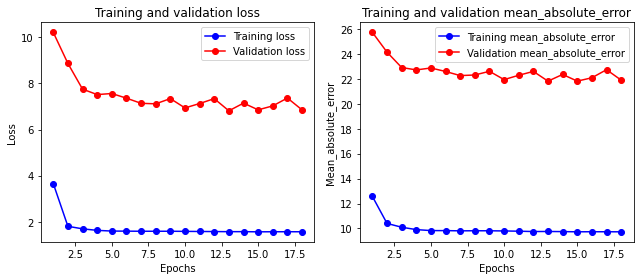

In [ ]:
# Best genre model (in terms of curve evolution: dropout + augmentation)
checkpoint_filename = "cnn_age_lr0.001_epoch{epoch}_dropout"
hyperparameters = {
    "checkpoint_genre": "cnn_genre_lr0.001_epoch25_dropout_aug",

    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "n_fine_tuned_layers": 0,  # apart from the Denses, starting from the bottom of the network

    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters, True)

Model: "cnn_age"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048)              0   

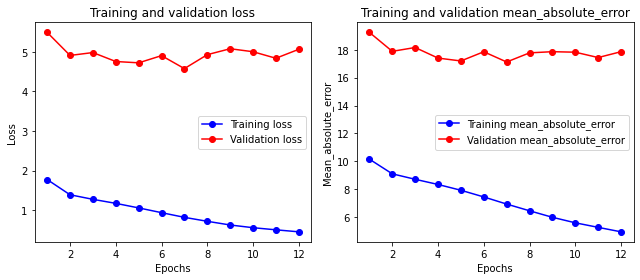

In [ ]:
# Best previous age model (baseline) fine-tuning the last layer
checkpoint_filename = "cnn_age_lr0.001_epoch{epoch}_finetuned"
hyperparameters = {
    "checkpoint_genre": "cnn_genre_lr0.001_epoch7",

    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "n_fine_tuned_layers": 3,  # apart from the Denses, starting from the bottom of the network

    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_age"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048)              0   

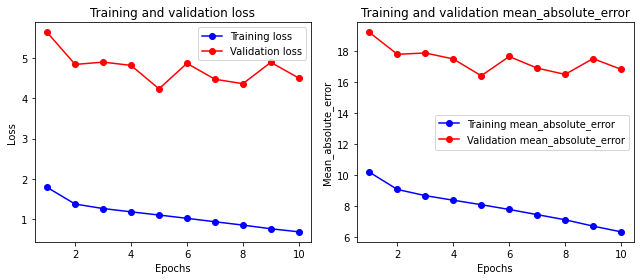

In [ ]:
# Best previous age model (baseline) fine-tuning the last 2 layers
checkpoint_filename = "cnn_age_lr0.001_epoch{epoch}_finetuned"
hyperparameters = {
    "checkpoint_genre": "cnn_genre_lr0.001_epoch7",

    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "n_fine_tuned_layers": 5,  # apart from the Denses, starting from the bottom of the network

    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_age"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048)              0   

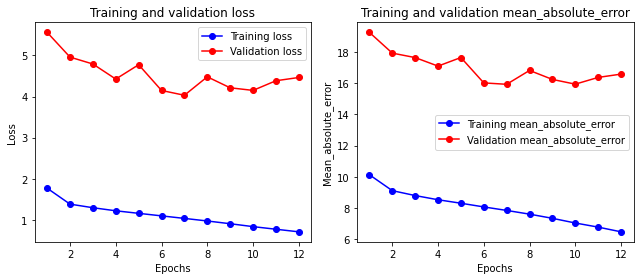

In [ ]:
# Best previous age model (baseline) fine-tuning all the model
checkpoint_filename = "cnn_age_lr0.001_epoch{epoch}_finetuned"
hyperparameters = {
    "checkpoint_genre": "cnn_genre_lr0.001_epoch7",

    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "n_fine_tuned_layers": 7,  # apart from the Denses, starting from the bottom of the network

    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

model, history = execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters)

Model: "cnn_age"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 4, 4, 128)         0   

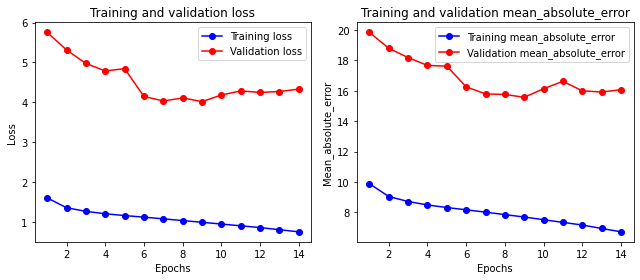

In [ ]:
# Test the training from scratch, to check if the use of a pre-trained model is really useful

# Depth is 3 because we are working with RGB images
inputs = keras.Input(shape=(img_height, img_width, 3), name="input")

# Feature extraction layers
x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", name="conv1")(inputs)
x = layers.MaxPooling2D(pool_size=2, name="pool1")(x)
x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", name="conv2")(x)
x = layers.MaxPooling2D(pool_size=2, name="pool2")(x)
x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", name="conv3")(x)
x = layers.MaxPooling2D(pool_size=2, name="pool3")(x)

# Classification layers
x = layers.Flatten(name="flatten")(x)
x = layers.Dense(1024, activation="relu", name="dense1")(x)
outputs = layers.Dense(1, activation="sigmoid", name="dense2")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="cnn_age")
model.summary()

hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizer_v2.adam.Adam,

    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=5),
    "checkpoint": None
}

history = train_model(model, ds_train_batch, ds_test_batch, hyperparameters["epochs"],
                        hyperparameters["lr"], hyperparameters["optimizer"],
                        hyperparameters["checkpoint"], hyperparameters["lr_scheduler"], hyperparameters["early_stop"])

plot_results(history, max_age)



# 4. Results

Two pre-trained models have been considered for applying transfer learning: the genre baseline model and the extension with dropout. The former was selected to have a reference to compare the results, and the latter because it was the model that showed one of the best results in validation.

Regarding the baseline model, we obtain a MAE of 8.2566 and 18.7308 in training and validation, respectively (unnormalized values using the factor `max_age=99`, no need to add the mean because the outputs were [0,1] normalized simply dividing by `max_age`). The difference between train and validation is rather significant, and the training is stopped soon because the generalization power of the network starts to decrease in epoch 6 (overfitting).

Testing now our selected regularized network, usign it as a simple feature extractor, and training only from scratch the last dense layers, we get even worse results: MAE of 9.603 and 20.5227 ages. Also, the networks starts to overfit in epoch 6.

As we overfit very soon in these experiments, we deciced to try the genre model with dropout and data augmentation, since it showed more appropiate evolution of the curves, completing the 25/25 epochs in the genre experiment (without overfitting detected). The results showed that the training last longer, but the performance was not improved, in fact, it even got worse: 21.8192 ages in validation. However, we see how a model that have difficulties to overfit in the genre problem shows more robustness when applying transfer learning on the age problem (it overfits much later than the previous models).

Since we were not able to improve the baseline results, we decided to use that configuration but now applying a fine-tuning approach, instead of feature extractor. The baseline model, without any kind of regularization, with the last convolutional layer fine-tuned gave a MAE of 17.127 ages in validation, improving considerable the results by more than 1 age. However, the network still overfitted too soon, in epoch 7.

We then tested to fine-tune the second and the first convolutional layers. They both improved the results of the previous experiments. Fine-tuning also the second layer gave a MAE of 16.4241 ages, while fine-tuning also the first layer gave a MAE of 15.9291 ages, in validation. They still overfit soon, after epoch 5 and 7, respectively.

We observed that as we train more parts of the networks, we got better results. Therefore, we also tried to train the whole baseline model from scratch, without a pre-trained model. Surprisingly, that was the best model among all the configurations tested, with a MAE of 15.5727 ages in validation (still overfitting after epoch 10).



# 5. Conclusions

The main conclusion of this experiment is that the **transfer learning was not successful** since the baseline model trained from scratch gave better results than using a pre-trained (regularized or not) model. This may be due to the fact that the features extracted to classify whether a person is a male/female are significantly different than to predict its age. For example, it could be the case that the genre model is just paying attention to the hair (short or long), something that would not be especially useful to predict the age. Explainable mechanisms may provide more information on this regard, and a permutation-based technique masking different parts of the input image may give interesting results to analyse the internal working of the model.

Due to the same reason, fine-tuning was a more appropiate approach since it allowed adapting the features extracted from the images, improving in turn a little bit the results, in comparison with the feature extractor approach.

We also observed that the regularization effects on the pre-trained model held for the transfer learning. For example, the model with dropout and data augmentation was the one whose training last longer, both in the genre and in the age problems. However, it seems that the regularization is not useful in terms of accuracy since the baseline model obtained better results than its counterparts with dropout.

In [ ]:
%%shell
jupyter nbconvert --to html 'P1_CNN_Age.ipynb'

[NbConvertApp] Converting notebook P1_CNN_Age.ipynb to html
[NbConvertApp] Writing 979225 bytes to P1_CNN_Age.html
